In [ ]:
import tensorflow as tf
import re
import numpy as np
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [ ]:
### Helper functions
import pickle

def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))


def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import pickle
train_audio_emb, val_audio_emb, test_audio_emb = pickle.load(open("/gdrive/My Drive/Emotion detection/audio_embeddings_feature_selection_emotion.pkl", 'rb'))

In [ ]:
len(train_audio_emb)

9989

We had already processed the data for you. You can find the pickle file [here](https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/data/merged_training.pkl).

In [ ]:
# load data
data = pd.read_csv("train_sent_emo_1.csv")
#data.emotions.value_counts().plot.bar()

In [ ]:
data

,text,emotions
0,also I was the point person on my companys tr...,neutral
1,You mustve had your hands full.,neutral
2,That I did. That I did.,neutral
3,So lets talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
9984,You or me?,neutral
9985,"I got it. Uh, Joey, women don't have Adam's ap...",neutral
9986,"You guys are messing with me, right?",surprise
9987,Yeah.,neutral


In [ ]:
data_ind = data.index
data_ind

RangeIndex(start=0, stop=9989, step=1)

In [ ]:
data

,text,emotions,token_size
1315,"Yeah, for you!",joy,3
9346,I mean doesn't she have any y'know other strip...,anger,14
6624,I know!! Chip? Hi! Its Monica. Kay. Kay...,joy,24
5929,"Yeah, thats what I drive. I make four bucks a...",disgust,17
2986,Remember that guy from cooking school I told y...,neutral,15
...,...,...,...
7469,So I guess what I'm trying to say is that I'm ...,joy,19
192,What?,neutral,1
8961,And you really think this is a good idea?,sadness,9
8561,Okay. I went down to the Mattress King showr...,sadness,17


In [ ]:
data

,text,emotions,token_size
1315,"Yeah, for you!",joy,3
9346,I mean doesn't she have any y'know other strip...,anger,14
6624,I know!! Chip? Hi! Its Monica. Kay. Kay...,joy,24
5929,"Yeah, thats what I drive. I make four bucks a...",disgust,17
2986,Remember that guy from cooking school I told y...,neutral,15
...,...,...,...
7469,So I guess what I'm trying to say is that I'm ...,joy,19
192,What?,neutral,1
8961,And you really think this is a good idea?,sadness,9
8561,Okay. I went down to the Mattress King showr...,sadness,17


### 3.1 Preprocessing Data
In the next steps we are going to create tokenize the text, create index mapping for words, and also construct a vocabulary. 

#### Tokenization and Sampling

In [ ]:
# retain only text that contain less that 70 tokens to avoid too much padding
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 70].copy()

# sampling
data = data.sample(n=9989);

#### Constructing Vocabulary and Index-Word Mapping

In [ ]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  

In [ ]:
# construct vocab and indexing
inputs = ConstructVocab(data["text"].values.tolist())

# examples of what is in the vocab
inputs.vocab[0:10]

['',
 '!',
 '"Benefits',
 '"Big',
 '"Blood"',
 '"Butternut',
 '"Captain',
 '"Circle',
 '"Daddy,',
 '"Days"']

### 3.2 Converting Data into Tensors 
For convenience we would like to convert the data into tensors. 

In [ ]:
# vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [ ]:
# examples of what is in the input tensors
input_tensor[0:2]

[[2831,
  4650,
  6888,
  8182,
  5467,
  8052,
  5247,
  8173,
  3224,
  7891,
  3277,
  10201,
  5389,
  8108,
  3277,
  3073,
  10997,
  11339,
  6396,
  6939,
  7096,
  8203,
  3277,
  9878,
  7779,
  6173,
  3277,
  10451,
  7779,
  7829],
 [2994, 8089]]

### 3.3 Padding data
In order to train our recurrent neural network later on in the notebook, it is required padding to generate inputs of same length.

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

69


In [ ]:
# Padding the input and output tensor to the maximum length
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                             maxlen=max_length_inp,
                                                             padding='post')

In [ ]:
input_tensor[0:2]

array([[ 2831,  4650,  6888,  8182,  5467,  8052,  5247,  8173,  3224,
         7891,  3277, 10201,  5389,  8108,  3277,  3073, 10997, 11339,
         6396,  6939,  7096,  8203,  3277,  9878,  7779,  6173,  3277,
        10451,  7779,  7829,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [ 2994,  8089,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     

In [ ]:
print(input_tensor.shape)
print(input_tensor)

(9989, 69)
[[ 2831  4650  6888 ...     0     0     0]
 [ 2994  8089     0 ...     0     0     0]
 [ 2629  7952 10541 ...     0     0     0]
 ...
 [  378  1308 11212 ...     0     0     0]
 [ 1954  3128  1308 ...     0     0     0]
 [ 1225 11337 10965 ...     0     0     0]]


### 3.4 Binarization
We would like to binarize our target so that we can obtain one-hot encodings as target values. These are easier and more efficient to work with and will be useful when training the models.

In [ ]:
### convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)
# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [ ]:
target_tensor[0:2] 

array([[0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0]])

In [ ]:
data[0:2]

,text,emotions,token_size
2329,We couldnt keep our eyes off each other all n...,joy,30
1229,"Yeah, okay.",neutral,2


In [ ]:
data.emotions.unique()

array(['joy', 'neutral', 'fear', 'surprise', 'anger', 'sadness',
       'disgust'], dtype=object)

In [ ]:
get_emotion = lambda t: np.argmax(t)

In [ ]:
get_emotion(target_tensor[0])

3

In [ ]:
emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'disgust', 4: 'sadness', 5: 'surprise',6: 'neutral'}

In [ ]:
emotion_dict[get_emotion(target_tensor[0])]

'disgust'

### 3.5 Split data
We would like to split our data into a train and validation set. In addition, we also want a holdout dataset (test set) for evaluating the models.

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(7991, 7991, 999, 999, 999, 999)

### 3.6 Data Loader
We can also load the data into a data loader, which makes it easy to **manipulate the data**, **create batches**, and apply further **transformations**. In TensorFlow we can use the `tf.data` function.

In [ ]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = num_emotions

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, 
                                                    target_tensor_train)).shuffle(TRAIN_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, 
                                                  target_tensor_val)).shuffle(VAL_BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_test, 
                                                    target_tensor_test)).shuffle(TEST_BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

print(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)

11400 256 1024 64 7


In [ ]:
# checking minibatch
print(train_dataset)
print(val_dataset)
print(test_dataset)

<BatchDataset shapes: ((64, 69), (64, 7)), types: (tf.int32, tf.int64)>
<BatchDataset shapes: ((64, 69), (64, 7)), types: (tf.int32, tf.int64)>
<BatchDataset shapes: ((64, 69), (64, 7)), types: (tf.int32, tf.int64)>


## 4. Model
After the data has been preprocessed, transformed and prepared it is now time to construct the model or the so-called computation graph that will be used to train our classification models. We are going to use a gated recurrent neural network (GRU), which is considered a more efficient version of a basic RNN. The figure below shows a high-level overview of the model details. 

![alt txt](https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/img/gru-model.png?raw=true)

### 4.1 Constructing the Model
Below we construct our model:

In [ ]:
### define the GRU component
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    if tf.test.is_gpu_available():
        return tf.compat.v1.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='relu', 
                               recurrent_initializer='glorot_uniform')

### Build the model
class EmoGRU(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        
        # layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.gru = gru(self.hidden_units)
        self.fc = tf.keras.layers.Dense(output_size)
        
    def call(self, x, hidden ):
        x = self.embedding(x) # batch_size X max_len X embedding_dim
        output, state = self.gru(x, initial_state = hidden) #  batch_size X max_len X hidden_units
        out = output[:,-1,:]
        out = self.dropout(out)
        out = self.fc(out) # batch_size X max_len X output_size
        return out, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.hidden_units))

### 4.1 Pretesting model
Since eager execution is enabled we can print the output of the model by passing a sample of the dataset and making sure that the dimensions of the outputs are as expected.

In [ ]:
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)

print(model)

# initialize the hidden state of the RNN
hidden = model.initialize_hidden_state()

# testing for the first batch only then break the for loop
# Potential bug: out is not randomized enough
for (batch, (inp, targ)) in enumerate(train_dataset):
  print(inp.shape)
  out, state = model(inp, hidden)
  print(out.shape) 
  break

(64, 69)
(64, 7)


## 5. Training the Model
Now that we have tested the model, it is time to train it. We will define our optimization algorithm, learning rate, and other necessary information to train the model.

In [ ]:
optimizer = tf.optimizers.Adam()

def loss_function(y, prediction):
    return tf.compat.v1.losses.softmax_cross_entropy(y, logits=prediction)

def accuracy(y, yhat):
    #compare the predictions to the truth
    yhat = tf.argmax(yhat, 1).numpy()
    y    = tf.argmax(y   , 1).numpy()
    return np.sum(y == yhat)/len(y)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    hidden = model.initialize_hidden_state()
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ)) in enumerate(train_dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            predictions,_ = model(inp, hidden)
            loss += loss_function(targ, predictions)
        batch_loss = (loss / int(targ.shape[1]))        
        total_loss += batch_loss
        
        batch_accuracy = accuracy(targ, predictions)
        train_accuracy += batch_accuracy
        
        gradients = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(gradients, model.variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
            
    ### Validating
    hidden = model.initialize_hidden_state()

    for (batch, (inp, targ)) in enumerate(val_dataset):        
        predictions,_ = model(inp, hidden)        
        batch_accuracy = accuracy(targ, predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             total_loss / TRAIN_N_BATCH, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.2594
Epoch 1 Batch 100 Val. Loss 0.2192
Epoch 1 Loss 0.2220 -- Train Acc. 0.4704 -- Val Acc. 0.4760
Time taken for 1 epoch 582.3811366558075 sec

Epoch 2 Batch 0 Val. Loss 0.2227


KeyboardInterrupt: ignored

In [ ]:
model.summary()

## 6. Evaluation on the Testing Data
Now we will evaluate the model with the holdout dataset.

In [ ]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

model.batch_sz = 64
hidden = model.initialize_hidden_state()
print(test_dataset)
for (batch, (inp, targ)) in enumerate(test_dataset): 
  #print(batch , inp.shape  , targ.shape) 
  #print('inp:',inp)      
  predictions,_ = model(inp, hidden)        
  batch_accuracy = accuracy(targ, predictions)
  test_accuracy += batch_accuracy
  
  x_raw = x_raw + [x for x in inp]
  y_raw = y_raw + [y for y in targ]
  
  all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy/TEST_N_BATCH)
print(len(all_predictions))

<BatchDataset shapes: ((64, 38), (64, 7)), types: (tf.int32, tf.int64)>
Test Accuracy:  0.546875
1


In [ ]:
print(np.array(x_raw).shape)
print(np.array(y_raw).shape)


(64, 38)
(64, 7)


In [ ]:
!pip install ffmpeg moviepy
import moviepy.editor as mp

  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=ba1e93f0f5b98320ddf89d327a358a792c1389b507c57d5bb04b4c561303b068
  Stored in directory: /root/.cache/pip/wheels/64/80/6e/caa3e16deb0267c3cbfd36862058a724144e19fdb9eb03af0f
Successfully built ffmpeg
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3153920/45929032 bytes (6.9%)6823936/45929032 bytes (14.9%)10747904/45929032 bytes (23.4%)14737408/45929032 bytes (32.1%)18784256/45929032 bytes (40.9%)22716416/45929032 bytes (49.5%)26574848/45929032 bytes (57.9%)30220288/45929032 bytes (65

In [ ]:
!pip install SpeechRecognition
import os
import speech_recognition as sr


     |████████████████████████████████| 32.8 MB 33 kB/s 


In [ ]:
my_clip = mp.VideoFileClip(r"testvideo.mp4")


In [ ]:
my_clip.audio.write_audiofile(r"test_result.wav")

[MoviePy] Writing audio in test_result.wav


100%|██████████| 10797/10797 [00:03<00:00, 2721.26it/s]

[MoviePy] Done.


In [ ]:
converted_wav = 'test_result.wav'
os.system(converted_wav)

32512

In [ ]:
r = sr.Recognizer()
audio = sr.AudioFile("test_result.wav")

In [ ]:
with audio as source:
  audio = r.record(source, duration=200)
  output_string = r.recognize_google(audio)

In [ ]:
output_string

"welcome to speak English with Tiffany I am teacher Tiffany and today I am going to teach you exactly how to give a five-minute speech and English this lesson will help you speak English more confidently in front of people are you ready to learn how well then let's Jump Right In giving a speech is not easy especially when it is an English but there are four easy steps that can help you give an amazing speech in English let's begin Step 1 the attention grabber the attention grabber is the starting point of every speech it is the step where we get grab and hold the attention of the audience there are three types of attention Grabbers the first one is is a story for this one you start off by telling a short story that connects to your speech and is also engaging the second one is an interesting fact for this one you want to tell and intriguing fact that directly relates to your topic and the third one is a question-and-answer time for this one your goal is to ask thought-provoking questio

In [ ]:
n = 15

def group_words(s, n):
    words = s.split()
    for i in range(0, len(words), n):
        yield ' '.join(words[i:i+n])

out_list = list(group_words(output_string,n))
out_list

['welcome to speak English with Tiffany I am teacher Tiffany and today I am going',
 'to teach you exactly how to give a five-minute speech and English this lesson will',
 'help you speak English more confidently in front of people are you ready to learn',
 "how well then let's Jump Right In giving a speech is not easy especially when",
 'it is an English but there are four easy steps that can help you give',
 "an amazing speech in English let's begin Step 1 the attention grabber the attention grabber",
 'is the starting point of every speech it is the step where we get grab',
 'and hold the attention of the audience there are three types of attention Grabbers the',
 'first one is is a story for this one you start off by telling a',
 'short story that connects to your speech and is also engaging the second one is',
 'an interesting fact for this one you want to tell and intriguing fact that directly',
 'relates to your topic and the third one is a question-and-answer time for this one'

In [ ]:
out_data = pd.DataFrame(out_list , columns = ['text'])
out_data['token_size'] = out_data['text'].apply(lambda x: len(x.split(' ')))
out_data = out_data.loc[out_data['token_size'] < 70].copy()
print(out_data)

inputs = ConstructVocab(out_data["text"].values.tolist())
print(inputs)
# examples of what is in the vocab
print(inputs.vocab[0:10])

# vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in out_data["text"].values.tolist()]
print(input_tensor)

# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

# Padding the input and output tensor to the maximum length
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp,padding='post')

print(input_tensor.shape)
#input_tensor = tf.convert_to_tensor(input_tensor, dtype=None, dtype_hint=None, name=None)
#print(input_tensor)

                                                 text  token_size
0   welcome to speak English with Tiffany I am tea...          15
1   to teach you exactly how to give a five-minute...          15
2   help you speak English more confidently in fro...          15
3   how well then let's Jump Right In giving a spe...          15
4   it is an English but there are four easy steps...          15
5   an amazing speech in English let's begin Step ...          15
6   is the starting point of every speech it is th...          15
7   and hold the attention of the audience there a...          15
8   first one is is a story for this one you start...          15
9   short story that connects to your speech and i...          15
10  an interesting fact for this one you want to t...          15
11  relates to your topic and the third one is a q...          15
12  your goal is to ask thought-provoking question...          15
13  to this will get them engaged with you from th...          15
14  our sp

In [ ]:
#print(dir(model))
test_new_pred1 = []
model.batch_sz = 1
hidden = model.initialize_hidden_state()
print(input_tensor.shape)

for inp in input_tensor :
  #print(inp.shape)
  inp = np.reshape(inp , (1,inp.shape[0]))
  inp = tf.convert_to_tensor(inp,dtype=None, dtype_hint=None, name=None)
  pred,_ = model(inp , hidden)
  #print(pred.shape)
  pred = pred[0].numpy()
  #print(pred)
  test_new_pred1.append(pred)

test_new_pred1[0:5]

(27, 15)


[array([ 4.1617355 , -1.9440538 , -2.26865   , -0.51516885,  5.2207503 ,
        -6.524542  ], dtype=float32),
 array([ 1.2273123 ,  1.562949  ,  0.7866119 ,  1.5913186 ,  6.113726  ,
        -0.82308304], dtype=float32),
 array([ 1.5132926, -6.7257605,  6.974586 ,  1.2493888,  4.527441 ,
        -6.7480464], dtype=float32),
 array([ 7.7808867 , -0.64428836,  5.3262653 , -4.068712  ,  4.639493  ,
        -7.63592   ], dtype=float32),
 array([-1.4907353, -2.6419609, 10.600937 ,  0.5117225,  5.833318 ,
        -1.7351737], dtype=float32)]

In [ ]:
data.iloc[data.index[0]]['text']

'i wonder if im being at all realistic here because i feel like when i get fond of someone i typically view them in a somewhat idealized way'

In [ ]:
##check this
def get_emotion1(pred):
  dif = abs(pred - np.ones(6))
  print(dif)
  em = np.argmin(dif)
  return em

In [ ]:
motion_pred = []
for i in range(0, len(test_new_pred1)):
  pred = test_new_pred1[i]
  em = get_emotion(pred)  #get_emotion1(pred)
  em = emotion_dict[em]
  txt = out_data.iloc[i]['text']
  print(txt , '------>' , em)

welcome to speak English with Tiffany I am teacher Tiffany and today I am going ------> sadness
to teach you exactly how to give a five-minute speech and English this lesson will ------> sadness
help you speak English more confidently in front of people are you ready to learn ------> joy
how well then let's Jump Right In giving a speech is not easy especially when ------> anger
it is an English but there are four easy steps that can help you give ------> joy
an amazing speech in English let's begin Step 1 the attention grabber the attention grabber ------> anger
is the starting point of every speech it is the step where we get grab ------> anger
and hold the attention of the audience there are three types of attention Grabbers the ------> anger
first one is is a story for this one you start off by telling a ------> fear
short story that connects to your speech and is also engaging the second one is ------> surprise
an interesting fact for this one you want to tell and intriguing fact t

In [ ]:
emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

In [ ]:
hidden

<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
data[0:2]

,text,emotions,token_size
17734,i cannot help saying that i feel you are less ...,joy,21
87897,i havent been this weight in years and im feel...,joy,12


### 6.1 Confusion Matrix
The test accuracy alone is not an interesting performance metric in this case. Let's plot a confusion matrix to get a drilled down view of how the model is performing with regards to each emotion.

In [ ]:
### Class to Properly Evaluate our Models
class Evaluate():

    def va_dist(cls, prediction, target, va_df, binarizer, name='', silent=False):
        """ Computes distance between actual and prediction through cosine distance """
        va_matrix = va_df.loc[binarizer.classes_][['valence','arousal']].values
        y_va = target.dot(va_matrix)
        F_va = prediction.dot(va_matrix)

        # dist is a one row vector with size of the test data passed(emotion)
        dist = metrics.pairwise.paired_cosine_distances(y_va, F_va)
        res = stats.describe(dist)

        # print by default (if silent=False)
        if not silent:
            print('%s\tmean: %f\tvariance: %f' % (name, res.mean, res.variance))

        return {
            'distances': dist,
            'dist_stat': res
        }

    def evaluate_class(cls, predictions, target, target2=None, silent=False):
        """ Compute only the predicted class """
        p_2_annotation = dict()

        precision_recall_fscore_support = [
            (pair[0], pair[1].mean()) for pair in zip(
                ['precision', 'recall', 'f1', 'support'],
                metrics.precision_recall_fscore_support(target, predictions)
            )
        ]

        metrics.precision_recall_fscore_support(target, predictions)

        # confusion matrix
        le = LabelEncoder()
        target_le = le.fit_transform(target)
        predictions_le = le.transform(predictions)
        cm = metrics.confusion_matrix(target_le, predictions_le)

        # prediction if two annotations are given on test data
        if target2:
            p_2_annotation = pd.DataFrame(
                [(pred, pred in set([t1,t2])) for pred, t1, t2 in zip(predictions, target, target2)],
                columns=['emo','success']
            ).groupby('emo').apply(lambda emo: emo.success.sum()/ len(emo.success)).to_dict()

        if not silent:
            print("Default Classification report")
            print(metrics.classification_report(target, predictions))

            # print if target2 was provided
            if len(p_2_annotation) > 0:
                print('\nPrecision on 2 annotations:')
                for emo in p_2_annotation:
                    print("%s: %.2f" % (emo, p_2_annotation[emo]))

            # print accuracies, precision, recall, and f1
            print('\nAccuracy:')
            print(metrics.accuracy_score(target, predictions))
            print("Correct Predictions: ", metrics.accuracy_score(target, predictions,normalize=False))
            for to_print in precision_recall_fscore_support[:3]:
                print( "%s: %.2f" % to_print )

            # normalizing the values of the consfusion matrix
            print('\nconfusion matrix\n %s' % cm)
            print('(row=expected, col=predicted)')
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cls.plot_confusion_matrix(cm_normalized, le.classes_, 'Confusion matrix Normalized')

        return {
            'precision_recall_fscore_support': precision_recall_fscore_support,
            'accuracy': metrics.accuracy_score(target, predictions),
            'p_2_annotation': p_2_annotation,
            'confusion_matrix': cm
        }

    def predict_class(cls, X_train, y_train, X_test, y_test,
                      pipeline, silent=False, target2=None):
        """ Predicted class,then run some performance evaluation """
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict(X_test)
        print("predictions computed....")
        return cls.evaluate_class(predictions, y_test, target2, silent)

    def evaluate_prob(cls, prediction, target_rank, target_class, binarizer, va_df, silent=False, target2=None):
        """ Evaluate through probability """
        # Run normal class evaluator
        predict_class = binarizer.classes_[prediction.argmax(axis=1)]
        class_eval = cls.evaluate_class(predict_class, target_class, target2, silent)

        if not silent:
            print('\n - First Emotion Classification Metrics -')
            print('\n - Multiple Emotion rank Metrics -')
            print('VA Cosine Distance')

        classes_dist = [
            (
                emo,
                cls.va_dist(
                    prediction[np.array(target_class) == emo],
                    target_rank[np.array(target_class) == emo],
                    va_df,
                    binarizer,
                    emo,
                    silent)
                ) for emo in binarizer.classes_
        ]
        avg_dist = cls.va_dist(prediction, target_rank, va_df, binarizer, 'avg', silent)

        coverage_error = metrics.coverage_error(target_rank, prediction)
        average_precision_score = metrics.average_precision_score(target_rank, prediction)
        label_ranking_average_precision_score = metrics.label_ranking_average_precision_score(target_rank, prediction)
        label_ranking_loss = metrics.label_ranking_loss(target_rank, prediction)

        # recall at 2
        # obtain top two predictions
        top2_pred = [set([binarizer.classes_[i[0]], binarizer.classes_[i[1]]]) for i in (prediction.argsort(axis=1).T[-2:].T)]
        recall_at_2 = pd.DataFrame(
            [
            t in p for t, p in zip(target_class, top2_pred)
            ], index=target_class, columns=['recall@2']).groupby(level=0).apply(lambda emo: emo.sum()/len(emo))

        # combine target into sets
        if target2:
            union_target = [set(t) for t in zip(target_class, target2)]
        else:
            union_target = [set(t) for t in zip(target_class)]

        # precision at k
        top_k_pred = [
            [set([binarizer.classes_[i] for i in i_list]) for i_list in (prediction.argsort(axis=1).T[-i:].T)]
            for i in range(2, len(binarizer.classes_)+1)]
        precision_at_k = [
            ('p@' + str(k+2), np.array([len(t & p)/(k+2) for t, p in zip(union_target, top_k_pred[k])]).mean())
            for k in range(len(top_k_pred))]

        # do this if silent= False
        if not silent:
            print('\n')
            print(recall_at_2)
            print('\n')
            print('p@k')
            for pk in precision_at_k:
                print(pk[0] + ':\t' + str(pk[1]))
            print('\ncoverage_error: %f' % coverage_error)
            print('average_precision_score: %f' % average_precision_score)
            print('label_ranking_average_precision_score: %f' % label_ranking_average_precision_score)
            print('label_ranking_loss: %f' % label_ranking_loss)

        return {
            'class_eval': class_eval,
            'recall_at_2': recall_at_2.to_dict(),
            'precision_at_2': precision_at_k,
            'classes_dist': classes_dist,
            'avg_dist': avg_dist,
            'coverage_error': coverage_error,
            'average_precision_score': average_precision_score,
            'label_ranking_average_precision_score': label_ranking_average_precision_score,
            'label_ranking_loss': label_ranking_loss
        }


    def predict_prob(cls, X_train, y_train, X_test, y_test, label_test, pipeline, binarizer, va_df, silent=False, target2=None):
        """ Output predcations based on training and labels """
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict_proba(X_test)
        pred_to_mlb = [np.where(pipeline.classes_ == emo)[0][0] for emo in binarizer.classes_.tolist()]
        return cls.evaluate_prob(predictions[:,pred_to_mlb], y_test, label_test, binarizer, va_df, silent, target2)


    def plot_confusion_matrix(cls, cm, my_tags, title='Confusion matrix', cmap=plt.cm.Blues):
        """ Plotting the confusion_matrix"""
        plt.rc('figure', figsize=(4, 4), dpi=100)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(my_tags))
        target_names = my_tags
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
        # add normalized values inside the Confusion matrix
        fmt = '.2f'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Default Classification report
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         5
     disgust       0.00      0.00      0.00        13
        fear       0.00      0.00      0.00         1
     neutral       0.00      0.00      0.00         5
     sadness       0.55      1.00      0.71        35
    surprise       0.00      0.00      0.00         5

    accuracy                           0.55        64
   macro avg       0.09      0.17      0.12        64
weighted avg       0.30      0.55      0.39        64


Accuracy:
0.546875
Correct Predictions:  35
precision: 0.09
recall: 0.17
f1: 0.12

confusion matrix
 [[ 0  0  0  0  5  0]
 [ 0  0  0  0 13  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  5  0]
 [ 0  0  0  0 35  0]
 [ 0  0  0  0  5  0]]
(row=expected, col=predicted)


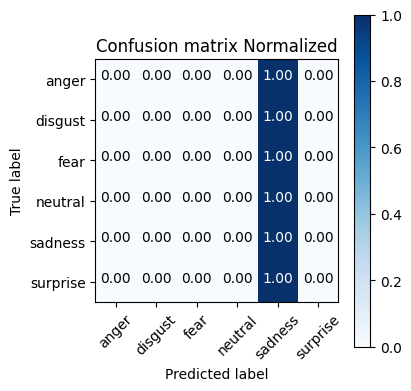

In [ ]:
evaluator = Evaluate()

final_predictions = []

for p in all_predictions:
    for sub_p in p:
        final_predictions.append(sub_p)

predictions = [np.argmax(p).item() for p in final_predictions]
targets = [np.argmax(t).item() for t in y_raw]
correct_predictions = float(np.sum(predictions == targets))

# predictions
predictions_human_readable = ((x_raw, predictions))
# actual targets
target_human_readable = ((x_raw,  targets))

emotion_dict =  {0: 'anger', 1: 'fear', 2: 'joy', 3: 'disgust', 4: 'sadness', 5: 'surprise',6: 'neutral'}

# convert results into dataframe
model_test_result = pd.DataFrame(predictions_human_readable[1],columns=["emotion"])
test = pd.DataFrame(target_human_readable[1], columns=["emotion"])

model_test_result.emotion = model_test_result.emotion.map(lambda x: emotion_dict[int(float(x))])
test.emotion = test.emotion.map(lambda x: emotion_dict[int(x)])

evaluator.evaluate_class(model_test_result.emotion, test.emotion );

We should input the real time streaming transcription model here that can be applied to live streams. For e.g: youtube.


In [ ]:
test

,emotion
0,surprise
1,sadness
2,sadness
3,disgust
4,anger
...,...
59,disgust
60,sadness
61,anger
62,sadness
